In [1]:
%%capture

! pip install evaluate
! pip install seqeval
! pip install -U accelerate
! pip install -U transformers

import sys
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import evaluate
import datasets
from datasets import Dataset, DatasetDict
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, DataCollatorForTokenClassification, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import my own functions from my_functions.py

path_to_module = '/content/drive/MyDrive/DTA/thesis/'
sys.path.append(path_to_module)
from my_functions import get_distribution, splitter, evaluator

# `PRICE` Entities: VARD Subcorpus

#### File and Directory Declarations

In [4]:
# — — NER subcorpus — —

# original NER subcorpus

data_file = "/content/drive/MyDrive/DTA/thesis/data/VARD_fscore_0.5_threshold_25.csv"

#### Data Preprocessing

In [5]:
# load the data

df = pd.read_csv(data_file)

# ensure all columns are read as strings

df = df.astype(str)

In [6]:
df.head()

,word_id,word_original,NAME,LOCATION,NATION,MARKET,DATE,TIME,PRICE,GOD,labels,old_word,word,POS
0,SB_J_1.0.0,1.,O,O,O,O,O,O,O,O,O,1.,1,NUM
1,SB_J_1.0.0.1,nan,O,O,O,O,O,O,O,O,O,nan,.,PUNCT
2,SB_J_1.0.1,HOTEL,B,O,O,O,O,O,O,O,NAME-B,HOTEL,HOTEL,PROPN
3,SB_J_1.0.2,JOHNSON,I,O,O,O,O,O,O,O,NAME-I,JOHNSON,JOHNSON,NOUN
4,SB_J_1.0.3,TO,O,O,O,O,O,O,O,O,O,TO,TO,ADP


In [7]:
# create label and numeric id dicts

labels_to_ids = {k: v for v, k in enumerate(df.NAME.unique())}
ids_to_labels = {v: k for v, k in enumerate(df.NAME.unique())}

In [8]:
# construct list of lists of tuples, with each list of tuples representing one line and its labels

data = [list(zip(g['word'], g['PRICE'])) for k, g in
            df.groupby(df['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(data)

# get distribution of stratified and shuffled data

dist = get_distribution(data)

# split the data into train and test

train_bin, test = splitter(data, 0.8, dist)

# split the test into eval and test

dist_test = get_distribution(test)

test_bin, eval_bin = splitter(test, 0.5, dist_test)

# we are splitting into 80% training data, 10% evaluation data, 10% training data

print(f"training data: {len(train_bin)}, evaluation data: {len(eval_bin)}, testing data: {len(test_bin)}")


Desired split: 0.8
Actual split: 0.8058
Desired split: 0.5
Actual split: 0.5088
training data: 1341, evaluation data: 159, testing data: 192


In [9]:
#  put into a dict form in preparation for converting to Dataset

train_data = []
for sublist in train_bin:
    tokens = []
    ner_tags = []
    for token, ner_tag in sublist:
        tokens.append(token)
        ner_tags.append(ner_tag)
    train_data.append({'tokens': tokens, 'ner_tags': ner_tags})

eval_data = []
for sublist in eval_bin:
    tokens = []
    ner_tags = []
    for token, ner_tag in sublist:
        tokens.append(token)
        ner_tags.append(ner_tag)
    eval_data.append({'tokens': tokens, 'ner_tags': ner_tags})

test_data = []
for sublist in test_bin:
    tokens = []
    ner_tags = []
    for token, ner_tag in sublist:
        tokens.append(token)
        ner_tags.append(ner_tag)
    test_data.append({'tokens': tokens, 'ner_tags': ner_tags})

In [10]:
# convert BIO to numeric labels using labels_to_ids dict

for entry in train_data:
    entry['ner_tags'] = [labels_to_ids[tag] for tag in entry['ner_tags']]

for entry in eval_data:
    entry['ner_tags'] = [labels_to_ids[tag] for tag in entry['ner_tags']]

for entry in test_data:
    entry['ner_tags'] = [labels_to_ids[tag] for tag in entry['ner_tags']]

In [11]:
# convert to Datasets

train_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=train_data))
eval_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=eval_data))
test_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=test_data))


# `bert-base-NER`

In [12]:
# define tokenizer

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")

In [13]:
# define function to realign tokens and labels, and truncate sequences
# '-100' is assigned to special tokens so that they are ignored by the loss function in training

# we need to specift a max_length of 512
# shorter labels will

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], padding=True, truncation=True, is_split_into_words=True, max_length=512)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # map tokens to their respective word
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # set the special tokens to -100
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # only label the first subtoken of a given word
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [14]:
# tokenize the training and evaluation data

train_tokenized = train_dataset.map(tokenize_and_align_labels, batched=True)
eval_tokenized = eval_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1341 [00:00<?, ? examples/s]

Map:   0%|          | 0/159 [00:00<?, ? examples/s]

In [15]:
train_tokenized, eval_tokenized

(Dataset({
     features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 1341
 }),
 Dataset({
     features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 159
 }))

In [16]:
# data collator that will dynamically pad the inputs received

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [17]:
# load the seqeval framework to compute metrics during training

seqeval = evaluate.load("seqeval")

In [18]:
# define function to compute metrics to pass to Trainer()
# we will assess with precision, recall, f1 macro average and accuracy

def compute_metrics(p):

    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

#### Model

In [19]:
# define model

model = AutoModelForTokenClassification.from_pretrained(
    "dslim/bert-base-NER", num_labels=3, id2label=ids_to_labels, label2id=labels_to_ids, ignore_mismatched_sizes=True
)

In [20]:
label_list = ["O", "B", "I"]

In [21]:
# define training arguments

training_args = TrainingArguments(
    output_dir="/bert-base-ner",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_strategy="steps",
    logging_steps=100,
)

# implement early stopping with a patience of 3

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

# define trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

# train model

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.022542,0.700000,0.625000,0.660377,0.994540
2,0.072000,0.010974,0.700000,0.750000,0.724138,0.995781
3,0.012700,0.012356,0.840000,0.750000,0.792453,0.996153
4,0.005500,0.008583,0.734375,0.839286,0.783333,0.997022
5,0.002300,0.008037,0.827586,0.857143,0.842105,0.998014
6,0.001300,0.011218,0.807018,0.821429,0.814159,0.997766
7,0.001300,0.012862,0.793103,0.821429,0.807018,0.997518
8,0.000900,0.012377,0.839286,0.839286,0.839286,0.997766


TrainOutput(global_step=672, training_loss=0.014165028913079627, metrics={'train_runtime': 1032.644, 'train_samples_per_second': 12.986, 'train_steps_per_second': 0.813, 'total_flos': 2764891718012880.0, 'train_loss': 0.014165028913079627, 'epoch': 8.0})

In [22]:
# store the model

trainer.save_model("/content/drive/MyDrive/DTA/thesis/models/price_vard_bert-base-ner")

#### Load Fine-Tuned Model

In [23]:
# Load the fine-tuned model and its tokenizer

model = AutoModelForTokenClassification.from_pretrained('/content/drive/MyDrive/DTA/thesis/models/price_vard_bert-base-ner')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/DTA/thesis/models/price_vard_bert-base-ner')

In [24]:
# prepare the test data for evaluation with the fine-tuned model

test_X = [" ".join(item[0] for item in inner_list) for inner_list in test_bin]
test_y = [[item[1] for item in inner_list] for inner_list in test_bin]

In [25]:
# make predictions with the test data

preds = []

for sent in test_X:

  # BERT-based models do not accept offset_mappings in their forward pass through the model: https://github.com/huggingface/transformers/issues/11828
  # we thus generate the offset map separately in a second instantiation of the tokenizer and save it instead of updating the model's signature

  map = tokenizer(sent, return_tensors="pt", return_offsets_mapping=True, max_length=512)
  input_map = map['offset_mapping']

  # tokenize the test data and generate the prediction

  input = tokenizer(sent, return_tensors="pt", max_length=512)

# tokenized_inputs = tokenizer(examples["tokens"], padding=True, truncation=True, is_split_into_words=True, max_length=512)

  with torch.no_grad():
    logits = model(**input).logits
  predictions = torch.argmax(logits, dim=2)
  predicted_tokens = [model.config.id2label[t.item()] for t in predictions[0]]


  # align the predictions at the subword level to the predictions at the word level, matching the indexing of the true labelling
  # we iterate through the tokenized test sentence and calculate the indices that denote the start of a token

  tokens = sent.split()
  token_indices = []
  current_index = 0
  for token in tokens:
      index = sent.find(token, current_index)
      token_indices.append(index)
      current_index = index + len(token)


  # ignore first and last elements of the array as they are special tokens

  arr_to_search = input_map[:, 1:-1, :]
  first_elements = arr_to_search[:, :, 0]

  # find the indices where the first element matches the search numbers

  result_indices = np.where(np.isin(first_elements, token_indices))

  # unpack the indices from the result_indices tuple

  matching_indices = result_indices[1]

  # because we ignored the the first special token we need to add 1 to the matching indices to preserve alignment

  modified_array = [num + 1 for num in matching_indices]

  predicted_sent = [predicted_tokens[i] for i in modified_array]

  preds.append(predicted_sent)

In [26]:
# due to some trucated sentence, we have to clip test_y up to the last predicted word predicted in test_X

test_y_trunc = []
for i,(f,g) in enumerate(zip(test_y, preds)):
  if len(f) != len(g):
    sliced_y = f[:len(g)]
    test_y_trunc.append(sliced_y)
    print(i,(len(f),len(g)))
  else:
      test_y_trunc.append(f)

In [27]:
# prepare list of predictions

flat_preds = [f for sublist in preds for f in sublist]

# create list of true labels

flat_true = [f for sublist in test_y_trunc for f in sublist]

# prepare labels

labels = ['B', 'I', 'O']

In [28]:
# save predictions

# truncate the test_X data
test_X_listed = [string.split() for string in test_X]
test_X_trunc = []
for i,(f,g) in enumerate(zip(test_X_listed, preds)):
  if len(f) != len(g):
    sliced_X = f[:len(g)]
    test_X_trunc.append(sliced_X)
    print(i,(len(f),len(g)))
  else:
      test_X_trunc.append(f)

# flatten the truncated test_X data
flat_test_X = [word for sublist in test_X_trunc for word in sublist]

# create df and save to disk
data = {
    'word': flat_test_X,
    'true_label': flat_true,
    'predictions': flat_preds
}

df = pd.DataFrame(data)

file_path = "/content/drive/MyDrive/DTA/thesis/models/price_vard_bert-base-ner.csv"
df.to_csv(file_path, index=False)

#### Evaluate

accuracy: 0.996614759647935
f1 average: 0.9066726540521476

precision: [0.83870968 0.81538462 0.99908414]
recall: [0.89655172 0.89830508 0.99794168]
f1: [0.86666667 0.85483871 0.99851259]

              precision    recall  f1-score   support

           B       0.84      0.90      0.87        58
           I       0.82      0.90      0.85        59
           O       1.00      1.00      1.00      8745

    accuracy                           1.00      8862
   macro avg       0.88      0.93      0.91      8862
weighted avg       1.00      1.00      1.00      8862



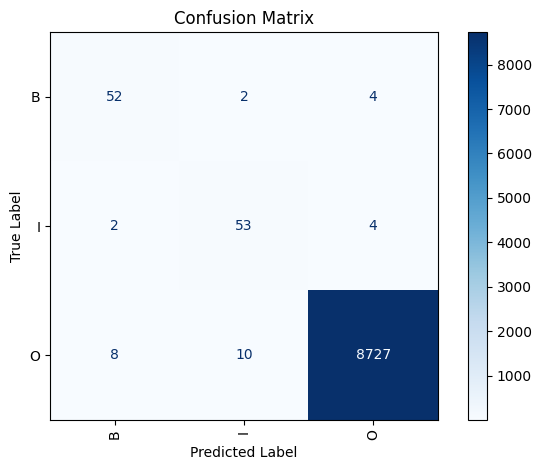

In [29]:
# evaluate

evaluator(flat_true, flat_preds, labels)

# `hmBERT`

In [30]:
# define tokenizer

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-historic-multilingual-cased")

In [31]:
# define function to realign tokens and labels, and truncate sequences
# '-100' is assigned to special tokens so that they are ignored by the loss function in training

# we need to specift a max_length of 512
# shorter labels will

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], padding=True, truncation=True, is_split_into_words=True, max_length=512)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # map tokens to their respective word
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # set the special tokens to -100
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # only label the first subtoken of a given word
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [32]:
# tokenize the training and evaluation data

train_tokenized = train_dataset.map(tokenize_and_align_labels, batched=True)
eval_tokenized = eval_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1341 [00:00<?, ? examples/s]

Map:   0%|          | 0/159 [00:00<?, ? examples/s]

In [33]:
train_tokenized, eval_tokenized

(Dataset({
     features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 1341
 }),
 Dataset({
     features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 159
 }))

In [34]:
# data collator that will dynamically pad the inputs received

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [35]:
# load the seqeval framework to compute metrics during training

seqeval = evaluate.load("seqeval")

#### Model

In [36]:
# define model

model = AutoModelForTokenClassification.from_pretrained(
    "dbmdz/bert-base-historic-multilingual-cased", num_labels=3, id2label=ids_to_labels, label2id=labels_to_ids
)

In [37]:
# define training arguments

training_args = TrainingArguments(
    output_dir="/hmbert",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_strategy="steps",
    logging_steps=100,
)

# implement early stopping with a patience of 3

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

# define trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

# train model

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.014095,0.722222,0.696429,0.709091,0.995532
2,0.067700,0.010876,0.636364,0.750000,0.688525,0.996153
3,0.011200,0.010389,0.745763,0.785714,0.765217,0.997518
4,0.005900,0.011224,0.745763,0.785714,0.765217,0.997270
5,0.002500,0.012145,0.698413,0.785714,0.739496,0.997270
6,0.001700,0.013457,0.737705,0.803571,0.769231,0.997394


TrainOutput(global_step=504, training_loss=0.01768181274371547, metrics={'train_runtime': 778.756, 'train_samples_per_second': 17.22, 'train_steps_per_second': 1.079, 'total_flos': 2102412712310784.0, 'train_loss': 0.01768181274371547, 'epoch': 6.0})

In [38]:
# store the model

trainer.save_model("/content/drive/MyDrive/DTA/thesis/models/price_vard_hmbert")

#### Load Fine-Tuned Model

In [39]:
# Load the fine-tuned model and its tokenizer

model = AutoModelForTokenClassification.from_pretrained('/content/drive/MyDrive/DTA/thesis/models/price_vard_hmbert')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/DTA/thesis/models/price_vard_hmbert')

In [40]:
# prepare the test data for evaluation with the fine-tuned model

test_X = [" ".join(item[0] for item in inner_list) for inner_list in test_bin]
test_y = [[item[1] for item in inner_list] for inner_list in test_bin]

In [41]:
# make predictions with the test data

preds = []

for sent in test_X:

  # BERT-based models do not accept offset_mappings in their forward pass through the model: https://github.com/huggingface/transformers/issues/11828
  # we thus generate the offset map separately in a second instantiation of the tokenizer and save it instead of updating the model's signature

  map = tokenizer(sent, return_tensors="pt", return_offsets_mapping=True, max_length=512)
  input_map = map['offset_mapping']

  # tokenize the test data and generate the prediction

  input = tokenizer(sent, return_tensors="pt", max_length=512)

# tokenized_inputs = tokenizer(examples["tokens"], padding=True, truncation=True, is_split_into_words=True, max_length=512)

  with torch.no_grad():
    logits = model(**input).logits
  predictions = torch.argmax(logits, dim=2)
  predicted_tokens = [model.config.id2label[t.item()] for t in predictions[0]]


  # align the predictions at the subword level to the predictions at the word level, matching the indexing of the true labelling
  # we iterate through the tokenized test sentence and calculate the indices that denote the start of a token

  tokens = sent.split()
  token_indices = []
  current_index = 0
  for token in tokens:
      index = sent.find(token, current_index)
      token_indices.append(index)
      current_index = index + len(token)


  # ignore first and last elements of the array as they are special tokens

  arr_to_search = input_map[:, 1:-1, :]
  first_elements = arr_to_search[:, :, 0]

  # find the indices where the first element matches the search numbers

  result_indices = np.where(np.isin(first_elements, token_indices))

  # unpack the indices from the result_indices tuple

  matching_indices = result_indices[1]

  # because we ignored the the first special token we need to add 1 to the matching indices to preserve alignment

  modified_array = [num + 1 for num in matching_indices]

  predicted_sent = [predicted_tokens[i] for i in modified_array]

  preds.append(predicted_sent)

In [42]:
# due to some trucated sentence, we have to clip test_y up to the last predicted word predicted in test_X

test_y_trunc = []
for i,(f,g) in enumerate(zip(test_y, preds)):
  if len(f) != len(g):
    sliced_y = f[:len(g)]
    test_y_trunc.append(sliced_y)
    print(i,(len(f),len(g)))
  else:
      test_y_trunc.append(f)

46 (447, 430)


In [43]:
# prepare list of predictions

flat_preds = [f for sublist in preds for f in sublist]

# create list of true labels

flat_true = [f for sublist in test_y_trunc for f in sublist]

# prepare labels

labels = ['B', 'I', 'O']

In [44]:
# save predictions

# truncate the test_X data
test_X_listed = [string.split() for string in test_X]
test_X_trunc = []
for i,(f,g) in enumerate(zip(test_X_listed, preds)):
  if len(f) != len(g):
    sliced_X = f[:len(g)]
    test_X_trunc.append(sliced_X)
    print(i,(len(f),len(g)))
  else:
      test_X_trunc.append(f)

# flatten the truncated test_X data
flat_test_X = [word for sublist in test_X_trunc for word in sublist]

# create df and save to disk
data = {
    'word': flat_test_X,
    'true_label': flat_true,
    'predictions': flat_preds
}

df = pd.DataFrame(data)

file_path = "/content/drive/MyDrive/DTA/thesis/models/price_vard_hmbert.csv"
df.to_csv(file_path, index=False)

46 (447, 430)


#### Evaluate

accuracy: 0.9971735443753533
f1 average: 0.9200767905297056

precision: [0.83606557 0.92857143 0.99873969]
recall: [0.87931034 0.88135593 0.99873969]
f1: [0.85714286 0.90434783 0.99873969]

              precision    recall  f1-score   support

           B       0.84      0.88      0.86        58
           I       0.93      0.88      0.90        59
           O       1.00      1.00      1.00      8728

    accuracy                           1.00      8845
   macro avg       0.92      0.92      0.92      8845
weighted avg       1.00      1.00      1.00      8845



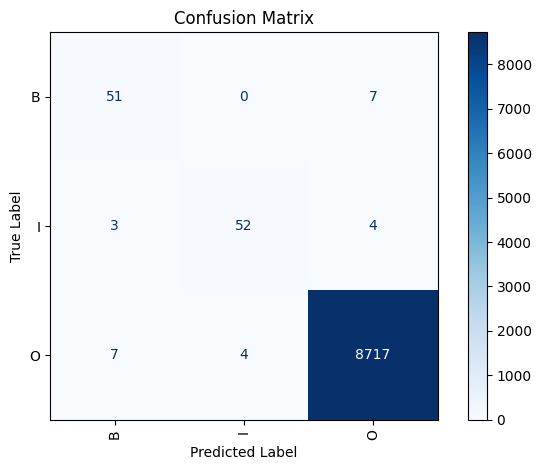

In [45]:
# evaluate

evaluator(flat_true, flat_preds, labels)

# `MacBERTh`

In [46]:
# define tokenizer

tokenizer = AutoTokenizer.from_pretrained("emanjavacas/MacBERTh")

In [47]:
# define function to realign tokens and labels, and truncate sequences
# '-100' is assigned to special tokens so that they are ignored by the loss function in training

# we need to specift a max_length of 512
# shorter labels will

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], padding=True, truncation=True, is_split_into_words=True, max_length=512)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # map tokens to their respective word
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # set the special tokens to -100
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # only label the first subtoken of a given word
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [48]:
# tokenize the training and evaluation data

train_tokenized = train_dataset.map(tokenize_and_align_labels, batched=True)
eval_tokenized = eval_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1341 [00:00<?, ? examples/s]

Map:   0%|          | 0/159 [00:00<?, ? examples/s]

In [49]:
train_tokenized, eval_tokenized

(Dataset({
     features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 1341
 }),
 Dataset({
     features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 159
 }))

In [50]:
# data collator that will dynamically pad the inputs received

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [51]:
# load the seqeval framework to compute metrics during training

seqeval = evaluate.load("seqeval")

#### Model

In [52]:
# define model

model = AutoModelForTokenClassification.from_pretrained(
    "emanjavacas/MacBERTh", num_labels=3, id2label=ids_to_labels, label2id=labels_to_ids)

In [53]:
label_list = ["O", "B", "I"]

In [54]:
# define training arguments

training_args = TrainingArguments(
    output_dir="/macberth",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_strategy="steps",
    logging_steps=100,
)

# implement early stopping with a patience of 3

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

# define trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

# train model

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.019926,0.461538,0.535714,0.495868,0.994664
2,0.076600,0.015233,0.561644,0.732143,0.635659,0.995408
3,0.015200,0.018120,0.472222,0.607143,0.531250,0.994664
4,0.009600,0.013276,0.585714,0.732143,0.650794,0.996029
5,0.005400,0.014363,0.656250,0.750000,0.700000,0.996153
6,0.003000,0.016664,0.689655,0.714286,0.701754,0.995532
7,0.003000,0.015560,0.632353,0.767857,0.693548,0.996029


TrainOutput(global_step=588, training_loss=0.01924737563141349, metrics={'train_runtime': 874.7841, 'train_samples_per_second': 15.329, 'train_steps_per_second': 0.96, 'total_flos': 2337839135824752.0, 'train_loss': 0.01924737563141349, 'epoch': 7.0})

In [55]:
# store the model

trainer.save_model("/content/drive/MyDrive/DTA/thesis/models/price_vard_macberth")

#### Load Fine-Tuned Model

In [56]:
# Load the fine-tuned model and its tokenizer

model = AutoModelForTokenClassification.from_pretrained('/content/drive/MyDrive/DTA/thesis/models/price_vard_macberth')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/DTA/thesis/models/price_vard_macberth')

In [57]:
# prepare the test data for evaluation with the fine-tuned model

test_X = [" ".join(item[0] for item in inner_list) for inner_list in test_bin]
test_y = [[item[1] for item in inner_list] for inner_list in test_bin]

In [58]:
# make predictions with the test data

preds = []

for sent in test_X:

  # BERT-based models do not accept offset_mappings in their forward pass through the model: https://github.com/huggingface/transformers/issues/11828
  # we thus generate the offset map separately in a second instantiation of the tokenizer and save it instead of updating the model's signature

  map = tokenizer(sent, return_tensors="pt", return_offsets_mapping=True, max_length=512)
  input_map = map['offset_mapping']

  # tokenize the test data and generate the prediction

  input = tokenizer(sent, return_tensors="pt", max_length=512)

# tokenized_inputs = tokenizer(examples["tokens"], padding=True, truncation=True, is_split_into_words=True, max_length=512)

  with torch.no_grad():
    logits = model(**input).logits
  predictions = torch.argmax(logits, dim=2)
  predicted_tokens = [model.config.id2label[t.item()] for t in predictions[0]]


  # align the predictions at the subword level to the predictions at the word level, matching the indexing of the true labelling
  # we iterate through the tokenized test sentence and calculate the indices that denote the start of a token

  tokens = sent.split()
  token_indices = []
  current_index = 0
  for token in tokens:
      index = sent.find(token, current_index)
      token_indices.append(index)
      current_index = index + len(token)


  # ignore first and last elements of the array as they are special tokens

  arr_to_search = input_map[:, 1:-1, :]
  first_elements = arr_to_search[:, :, 0]

  # find the indices where the first element matches the search numbers

  result_indices = np.where(np.isin(first_elements, token_indices))

  # unpack the indices from the result_indices tuple

  matching_indices = result_indices[1]

  # because we ignored the the first special token we need to add 1 to the matching indices to preserve alignment

  modified_array = [num + 1 for num in matching_indices]

  predicted_sent = [predicted_tokens[i] for i in modified_array]

  preds.append(predicted_sent)

In [59]:
# due to some trucated sentence, we have to clip test_y up to the last predicted word predicted in test_X

test_y_trunc = []
for i,(f,g) in enumerate(zip(test_y, preds)):
  if len(f) != len(g):
    sliced_y = f[:len(g)]
    test_y_trunc.append(sliced_y)
    print(i,(len(f),len(g)))
  else:
      test_y_trunc.append(f)

In [60]:
# prepare list of predictions

flat_preds = [f for sublist in preds for f in sublist]

# create list of true labels

flat_true = [f for sublist in test_y_trunc for f in sublist]

# prepare labels

labels = ['B', 'I', 'O']

In [61]:
# save predictions

# truncate the test_X data
test_X_listed = [string.split() for string in test_X]
test_X_trunc = []
for i,(f,g) in enumerate(zip(test_X_listed, preds)):
  if len(f) != len(g):
    sliced_X = f[:len(g)]
    test_X_trunc.append(sliced_X)
    print(i,(len(f),len(g)))
  else:
      test_X_trunc.append(f)

# flatten the truncated test_X data
flat_test_X = [word for sublist in test_X_trunc for word in sublist]

# create df and save to disk
data = {
    'word': flat_test_X,
    'true_label': flat_true,
    'predictions': flat_preds
}

df = pd.DataFrame(data)

file_path = "/content/drive/MyDrive/DTA/thesis/models/price_vard_macberth.csv"
df.to_csv(file_path, index=False)

#### Evaluate

accuracy: 0.9967276009930038
f1 average: 0.9098685110553429

precision: [0.83606557 0.86666667 0.99874156]
recall: [0.87931034 0.88135593 0.99828473]
f1: [0.85714286 0.87394958 0.9985131 ]

              precision    recall  f1-score   support

           B       0.84      0.88      0.86        58
           I       0.87      0.88      0.87        59
           O       1.00      1.00      1.00      8745

    accuracy                           1.00      8862
   macro avg       0.90      0.92      0.91      8862
weighted avg       1.00      1.00      1.00      8862



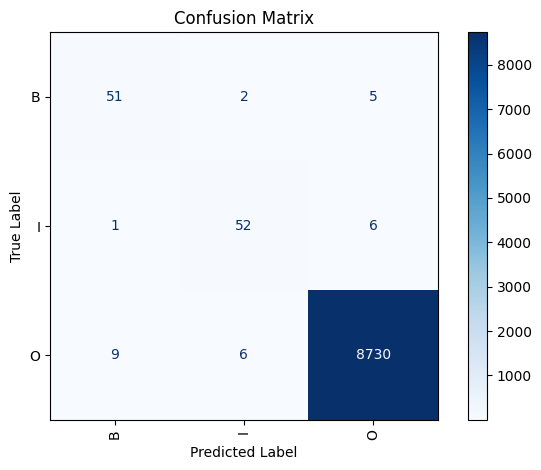

In [62]:
# evaluate

evaluator(flat_true, flat_preds, labels)